In [144]:

import os
import sys 
sys.path.insert(0, '../')

In [145]:
from torch.utils.data import DataLoader
import pandas as pd
from common.common import create_folder,H5Recorder
import numpy as np
from torch.utils.data.dataset import Dataset
import os
import torch
import torch.nn as nn
import pytorch_pretrained_bert as Bert

from model import optimiser
import sklearn.metrics as skm
import math
from torch.utils.data.dataset import Dataset
import random
import numpy as np
import torch
import time
from sklearn.metrics import roc_auc_score
from common.common import load_obj
from model.utils import age_vocab
from dataLoader.NextXVisit import NextVisit
from model.NextXVisit import BertForMultiLabelPrediction
import warnings
warnings.filterwarnings(action='ignore')

In [247]:
# Provide the path to the parquet file
file_path = "/data/datasets/leyang.sun/merged_age_diagnosis.csv"


# Read the DataFrame from the parquet file
original_data = pd.read_csv(file_path)

In [248]:
original_data['age_vector'] = original_data['age_vector'].apply(lambda x: ''.join([char for char in str(x) if (char != ' ' and char != '[' and char != ']')]).split(','))
original_data['age_vector'] = original_data['age_vector'].apply(lambda x: list(map(int, x)))

# Display the result for the first row

#print(original_data['age_vector'][0])

In [249]:
print(original_data['age_vector'][0])

[31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 33, 33, 33, 33, 35, 35]


In [250]:

# Assuming 'diagnosis_code' is a column in your DataFrame
original_data['diagnosis_code'] = original_data['diagnosis_code'].apply(lambda x: ''.join([char for char in str(x) if (char != ' ' and char != '[' and char != ']')]).split(','))
print(original_data['diagnosis_code'][0])

["'CLS'", '366.0', '366.0', '418.0', '705.0', '760.0', '838.0', '840.0', '844.0', '994.0', '1181.0', '1564.0', '1705.0', '1719.0', "'SEP'", '366.0', '760.0', '1181.0', '1564.0', "'SEP'", '579.0', "'SEP'", '579.0', "'SEP'", '838.0', '1729.0', "'SEP'", '840.0', "'SEP'", '1943.0', '1941.0', '1947.0', '1935.0', '1935.0', '1887.0', '1882.0', '1957.0', '1887.0', "'SEP'", '1915.0', '357.0', '357.0', '357.0', '1941.0', '1947.0', '1947.0', '1935.0', '1935.0', '1887.0', '1887.0', '1413.0', '1957.0', '1887.0', "'SEP'", '1947.0', '1935.0', '1887.0', '1957.0', "'SEP'", '1947.0', '1935.0', '1935.0', '1887.0', '1957.0', '1887.0', "'SEP'", '1947.0', '1935.0', '1935.0', '1887.0', '1957.0', '1887.0', "'SEP'", '1935.0', '1947.0', '1935.0', '1887.0', '1957.0', "'SEP'", '1935.0', "'SEP'", '1935.0', "'SEP'", '1943.0', '1941.0', '1947.0', '1947.0', '1949.0', '1935.0', '1887.0', '2016.0', '1934.0', '1903.0', '1882.0', '1957.0', '1887.0', "'SEP'", '1941.0', '1947.0', '1935.0', '1887.0', '1957.0', "'SEP'"]


In [251]:
print(original_data.head())

   Unnamed: 0             deid_pat_ID  \
0           0      IRB202001139_PAT_1   
1           1     IRB202001139_PAT_10   
2           2  IRB202001139_PAT_10001   
3           3  IRB202001139_PAT_10002   
4           4  IRB202001139_PAT_10009   

                                          age_vector  \
0  [31, 31, 31, 31, 31, 31, 32, 33, 33, 33, 33, 3...   
1  [69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 7...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 2...   
4  [66, 66, 66, 66, 67, 67, 67, 67, 67, 67, 67, 6...   

                                      diagnosis_code  
0  ['CLS', 366.0, 366.0, 418.0, 705.0, 760.0, 838...  
1  ['CLS', 1117.0, 1113.0, 65.0, 72.0, 366.0, 366...  
2  ['CLS', 35.0, 920.0, 1696.0, 'SEP', 388.0, 'SE...  
3  ['CLS', 492.0, 1531.0, 1534.0, 'SEP', 1707.0, ...  
4  ['CLS', 250.0, 579.0, 590.0, 590.0, 760.0, 824...  


In [252]:
# Save the train and test datasets

file_config = {
    'vocab': '/home/leyang.sun/BERHT/BEHRT/saved_vocab', # token2idx idx2token
    'train': '/home/leyang.sun/BERHT/BEHRT/train_data.parquet',
    'test': '/home/leyang.sun/BERHT/BEHRT/test_data.parquet'
}

In [253]:
#[ cls, 1,2, sep, 3,4 , sep, 4,5, sep, 2,4, sep,2,sep]
from sklearn.model_selection import train_test_split

def process_patient_data(row):
    # Count the number of visits for the patient
    total_visits = row['diagnosis_code'].count("'SEP'") 

    # Check if total visits is greater than 3
    if total_visits <= 3:
        return None

    # Choose a random index j for each patient (3 <= j < total_visits)
    j = np.random.randint(3, total_visits) # j =4
    # print(j)

    # Create x_p: visits from 1 to j
    x_p = row['age_vector'][:j]

    # Find the (j-1)th and jth 'SEP' indices

    # Assuming diagnosis_code is a list of strings and numbers
    converted_diagnosis_code = []

#     for code in row['diagnosis_code']:
#         print(code)   
        
#     print(len(row['diagnosis_code']))
    sep_indices = [i for i in range(len(row['diagnosis_code'])) if 'SEP' in str(row['diagnosis_code'][i])] # [3,6,9,12,14]
#     print(sep_indices)
#     print(j-2)
    sep_indices_j_minus_1 = sep_indices[j - 2] # sep_indices[2] = 9
    sep_indices_j = sep_indices[j - 1]

    # Create label: diagnosis_code after the (j-1)th 'SEP' and before the jth 'SEP'
    label = row['diagnosis_code'][sep_indices_j_minus_1 + 1:sep_indices_j]

    # Delete elements after the jth 'SEP'
    row['diagnosis_code'] = row['diagnosis_code'][:sep_indices_j]

    return pd.Series({'deid_pat_ID': row['deid_pat_ID'], 'age_vector': x_p, 'diagnosis_code': row['diagnosis_code'], 'label': label})

# Apply the function to each row of the original data
processed_data = original_data.apply(process_patient_data, axis=1)

# Drop rows where total visits is less than or equal to 3
processed_data = processed_data.dropna()

# Convert the lists to DataFrames
processed_data_df = pd.DataFrame(processed_data)

In [254]:
print(processed_data_df.head(20))

               deid_pat_ID                                         age_vector  \
0       IRB202001139_PAT_1                                   [31, 31, 31, 31]   
1      IRB202001139_PAT_10  [69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 7...   
2   IRB202001139_PAT_10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3   IRB202001139_PAT_10002  [19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 2...   
4   IRB202001139_PAT_10009                           [66, 66, 66, 66, 67, 67]   
6   IRB202001139_PAT_10014                                       [64, 65, 68]   
7   IRB202001139_PAT_10018  [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 5...   
8   IRB202001139_PAT_10020                                       [83, 83, 83]   
9   IRB202001139_PAT_10025  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...   
10  IRB202001139_PAT_10034  [48, 48, 49, 49, 49, 49, 49, 49, 49, 50, 50, 5...   
11  IRB202001139_PAT_10037                                       [46, 46, 46]   
12  IRB202001139_PAT_10039  

In [255]:

unique_elements = sorted(set([item for sublist in processed_data_df['label'] for item in sublist]))

# Create a new DataFrame with one-hot encoding
one_hot_df = pd.DataFrame()
for element in unique_elements:
    one_hot_df[element] = processed_data_df['label'].apply(lambda x: '1' if element in x else '0')

# Display the resulting DataFrame
# print(one_hot_df)


In [256]:
for index, row in one_hot_df.iterrows():
    label_list = row.tolist()
    processed_data_df.at[index, 'label'] = label_list

# Display the modified DataFrame
print(processed_data_df.head())

              deid_pat_ID                                         age_vector  \
0      IRB202001139_PAT_1                                   [31, 31, 31, 31]   
1     IRB202001139_PAT_10  [69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 7...   
2  IRB202001139_PAT_10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  IRB202001139_PAT_10002  [19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 2...   
4  IRB202001139_PAT_10009                           [66, 66, 66, 66, 67, 67]   

                                      diagnosis_code  \
0  ['CLS', 366.0, 366.0, 418.0, 705.0, 760.0, 838...   
1  ['CLS', 1117.0, 1113.0, 65.0, 72.0, 366.0, 366...   
2  ['CLS', 35.0, 920.0, 1696.0, 'SEP', 388.0, 'SE...   
3  ['CLS', 492.0, 1531.0, 1534.0, 'SEP', 1707.0, ...   
4  ['CLS', 250.0, 579.0, 590.0, 590.0, 760.0, 824...   

                                               label  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0

In [ ]:
# # Find the length of the longest list in the 'label' column
# max_length = max(len(lst) for lst in processed_data_df['label'])

# # Extend each list to the length of the longest list and fill with zeros
# processed_data_df['label'] = processed_data_df['label'].apply(lambda x: x + ['0'] * (max_length - len(x)))

In [257]:
processed_data_df['deid_pat_ID'] = processed_data_df['deid_pat_ID'].str.replace('IRB202001139_PAT_', '', regex=False)
# Display the revised DataFrame
print(processed_data_df.head(20))

   deid_pat_ID                                         age_vector  \
0            1                                   [31, 31, 31, 31]   
1           10  [69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 7...   
2        10001  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3        10002  [19, 19, 20, 20, 21, 21, 21, 22, 22, 22, 22, 2...   
4        10009                           [66, 66, 66, 66, 67, 67]   
6        10014                                       [64, 65, 68]   
7        10018  [58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 58, 5...   
8        10020                                       [83, 83, 83]   
9        10025  [48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4...   
10       10034  [48, 48, 49, 49, 49, 49, 49, 49, 49, 50, 50, 5...   
11       10037                                       [46, 46, 46]   
12       10039  [21, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 2...   
13        1004                           [30, 32, 32, 32, 32, 32]   
14       10040   [77, 77, 77, 77, 

In [276]:
# Split the data into train and test sets (80% train, 20% test)
train_data, test_data = train_test_split(processed_data_df, test_size=0.2, random_state=40)

# Convert the lists to DataFrames
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [277]:
# Rename columns
train_df = train_df.rename(columns={'age_vector': 'age', 'diagnosis_code': 'code', 'deid_pat_ID':'patid'})
test_df = test_df.rename(columns={'age_vector': 'age', 'diagnosis_code': 'code', 'deid_pat_ID':'patid'})


# Reset the index of train and test DataFrames
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Save DataFrames as Parquet files without the index column
train_df.to_parquet('/home/leyang.sun/BERHT/BEHRT/train_data.parquet', index=False)
test_df.to_parquet('/home/leyang.sun/BERHT/BEHRT/test_data.parquet', index=False)



In [278]:
print(train_df)

      patid                                                age  \
0     23430  [56, 57, 57, 57, 60, 60, 60, 60, 60, 60, 60, 6...   
1      7202                                   [67, 67, 68, 68]   
2     16812  [75, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 7...   
3      5631  [67, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 6...   
4     46842                                   [49, 49, 49, 49]   
...     ...                                                ...   
6353   2705   [69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 72]   
6354  44668                           [77, 77, 78, 78, 78, 78]   
6355    438           [67, 67, 67, 67, 67, 67, 67, 67, 67, 67]   
6356  44978                                   [18, 18, 18, 18]   
6357  28866                                       [42, 42, 42]   

                                                   code  \
0     ['CLS', 1523.0, 'SEP', 26.0, 1555.0, 1921.0, 1...   
1     ['CLS', 760.0, 357.0, 357.0, 366.0, 366.0, 466...   
2     ['CLS', 228.0, 612.0, 17

In [279]:
print(test_df)

      patid                                                age  \
0      3134  [76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 76, 7...   
1     18279  [75, 75, 75, 75, 75, 78, 78, 78, 78, 79, 79, 7...   
2      7867  [38, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...   
3     11816  [70, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7...   
4      6341                           [79, 80, 83, 83, 84, 84]   
...     ...                                                ...   
1585  41714                                   [65, 65, 65, 65]   
1586   4544                                       [82, 83, 83]   
1587  20257  [38, 38, 39, 39, 41, 41, 42, 42, 42, 42, 42, 4...   
1588  45164  [56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 5...   
1589  32501  [33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 3...   

                                                   code  \
0     ['CLS', 236.0, 345.0, 556.0, 558.0, 813.0, 'SE...   
1     ['CLS', 250.0, 577.0, 760.0, 777.0, 844.0, 150...   
2     ['CLS', 421.0, 415.0, 27

In [280]:
optim_config = {
    'lr': 1e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

global_params = {
    'batch_size': 256,
    'gradient_accumulation_steps': 1,
    'device': 'cuda:0',
    'output_dir': '/home/leyang.sun/BERHT/BEHRT/fine_tuned_model',# output folder
    'best_name': 'FineTuned_BERT_Large_Nextvisit',  # output model name
    'max_len_seq': 100,
    'max_age': 110,
    'age_year': False,
    'age_symbol': None,
    'min_visit': 5
}
pretrain_model_path = '/home/leyang.sun/BERHT/BEHRT/saved_model/BERT_Large_v1_2023-10-19'


In [281]:
BertVocab = load_obj(file_config['vocab'])

ageVocab, _ = age_vocab(max_age=global_params['max_age'], symbol=global_params['age_symbol'])

In [282]:
# create a new vocabulary for labels by removing specific tokens like 'PAD', 'SEP', 'CLS', and 'MASK' from the original vocabulary.
def format_label_vocab(token2idx):
    token2idx = token2idx.copy()
    del token2idx['PAD']
    del token2idx['SEP']
    del token2idx['CLS']
    del token2idx['MASK']
    token = list(token2idx.keys())
    labelVocab = {}
    for i,x in enumerate(token):
        labelVocab[x] = i
    return labelVocab

labelVocab = format_label_vocab(BertVocab['token2idx']) # return a dictionary called labelVocab

In [283]:
model_config = {
    'vocab_size': len(BertVocab['token2idx'].keys()), # number of disease + symbols for word embedding
    'hidden_size': 288, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': len(ageVocab.keys()), # number of vocab for age embedding
    'max_position_embedding': global_params['max_len_seq'], # maximum number of tokens
    'hidden_dropout_prob': 0.1, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 12, # number of attention heads
    'attention_probs_dropout_prob': 0.1, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
}

feature_dict = {
    'word':True,
    'seg':True,
    'age':True,
    'position': True
}

In [284]:
class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')

In [285]:
train = pd.read_parquet(file_config['train'])
Dset = NextVisit(token2idx=BertVocab['token2idx'], label2idx=labelVocab, age2idx=ageVocab, dataframe=train, max_len=global_params['max_len_seq'])
trainload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'], shuffle=True, num_workers=3)

In [286]:
test = pd.read_parquet(file_config['test'])
Dset = NextVisit(token2idx=BertVocab['token2idx'], label2idx=labelVocab, age2idx=ageVocab, dataframe=test, max_len=global_params['max_len_seq'])
testload = DataLoader(dataset=Dset, batch_size=global_params['batch_size'], shuffle=False, num_workers=3)

In [287]:
# del model
conf = BertConfig(model_config)
model = BertForMultiLabelPrediction(conf, num_labels=len(labelVocab.keys()), feature_dict=feature_dict)

In [288]:
# def load_model(path, model):
#     # load pretrained model and update weights
#     pretrained_dict = torch.load(path)
#     model_dict = model.state_dict()
#     # 1. filter out unnecessary keys
#     pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#     # 2. overwrite entries in the existing state dict
#     model_dict.update(pretrained_dict)
#     # 3. load the new state dict
#     model.load_state_dict(model_dict)
#     return model

def load_model(path, model):
    # load pretrained model and update weights
    pretrained_dict = torch.load(path)
    model_dict = model.state_dict()

    # Filter out unnecessary keys and skip the mismatched parameter
    pretrained_dict = {
        k: v for k, v in pretrained_dict.items() if k in model_dict and k != 'bert.embeddings.posi_embeddings.weight'
    }

    # Update entries in the existing state dict
    model_dict.update(pretrained_dict)

    # Load the new state dict
    model.load_state_dict(model_dict)
    return model


mode = load_model(pretrain_model_path, model)  # Loading Pretrained Model

In [289]:
model = model.to(global_params['device'])
optim = optimiser.adam(params=list(model.named_parameters()), config=optim_config)

t_total value of -1 results in schedule not being applied


In [290]:
import sklearn
def precision(logits, label):
    sig = nn.Sigmoid()
    output=sig(logits)
    label, output=label.cpu(), output.detach().cpu()
    tempprc= sklearn.metrics.average_precision_score(label.numpy(),output.numpy(), average='samples')
    return tempprc, output, label

def precision_test(logits, label):
    sig = nn.Sigmoid()
    output=sig(logits)
    tempprc= sklearn.metrics.average_precision_score(label.numpy(),output.numpy(), average='samples')
    roc = sklearn.metrics.roc_auc_score(label.numpy(),output.numpy(), average='samples')
    return tempprc, roc, output, label,

In [291]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=list(labelVocab.values()))
mlb.fit([[each] for each in list(labelVocab.values())])

MultiLabelBinarizer(classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                             15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
                             28, 29, ...])

In [292]:
def train(e, train_losses):
    model.train()
    tr_loss = 0
    temp_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    cnt = 0
    for step, batch in enumerate(trainload):
        cnt +=1
        age_ids, input_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)

        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
        
        loss, logits = model(input_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets)
        
        if global_params['gradient_accumulation_steps'] >1:
            loss = loss/global_params['gradient_accumulation_steps']
        loss.backward()
        
        temp_loss += loss.item()
        tr_loss += loss.item()
        nb_tr_examples += input_ids.size(0)
        nb_tr_steps += 1
        
        if step % 500==0:
            prec, a, b = precision(logits, targets)
            print("epoch: {}\t| Cnt: {}\t| Loss: {}\t| precision: {}".format(e, cnt,temp_loss/500, prec))
            temp_loss = 0
        
        if (step + 1) % global_params['gradient_accumulation_steps'] == 0:
            optim.step()
            optim.zero_grad()
            
    train_losses.append(tr_loss / nb_tr_steps)

def evaluation():
    model.eval()
    y = []
    y_label = []
    tr_loss = 0
    for step, batch in enumerate(testload):
        model.eval()
        age_ids, input_ids, posi_ids, segment_ids, attMask, targets, _ = batch
        targets = torch.tensor(mlb.transform(targets.numpy()), dtype=torch.float32)
        
        age_ids = age_ids.to(global_params['device'])
        input_ids = input_ids.to(global_params['device'])
        posi_ids = posi_ids.to(global_params['device'])
        segment_ids = segment_ids.to(global_params['device'])
        attMask = attMask.to(global_params['device'])
        targets = targets.to(global_params['device'])
        
        with torch.no_grad():
            loss, logits = model(input_ids, age_ids, segment_ids, posi_ids,attention_mask=attMask, labels=targets)
        logits = logits.cpu()
        targets = targets.cpu()
        
        tr_loss += loss.item()

        y_label.append(targets)
        y.append(logits)

    y_label = torch.cat(y_label, dim=0)
    y = torch.cat(y, dim=0)

    aps, roc, output, label = precision_test(y, y_label)
    return aps, roc, tr_loss

In [294]:
best_pre = 0.0
train_losses = []
for e in range(100):
    train(e, train_losses)
    aps, roc, test_loss = evaluation()
    if aps >best_pre:
        # Save a trained model
        print("** ** * Saving fine - tuned model ** ** * ")
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        output_model_file = os.path.join(global_params['output_dir'],global_params['best_name'])
        create_folder(global_params['output_dir'])

        torch.save(model_to_save.state_dict(), output_model_file)
        best_pre = aps
    print('aps : {}'.format(aps))

epoch: 0	| Cnt: 1	| Loss: 0.0013751969337463378	| precision: 0.0014972900430714048
** ** * Saving fine - tuned model ** ** * 
aps : 0.04508178709962442
epoch: 1	| Cnt: 1	| Loss: 0.0011457746028900146	| precision: 0.04745859302793386
** ** * Saving fine - tuned model ** ** * 
aps : 1.0
epoch: 2	| Cnt: 1	| Loss: 0.0008577525019645691	| precision: 0.9609375
aps : 1.0
epoch: 3	| Cnt: 1	| Loss: 0.0006443355083465577	| precision: 1.0
aps : 1.0
epoch: 4	| Cnt: 1	| Loss: 0.0005106017589569092	| precision: 1.0
aps : 1.0
epoch: 5	| Cnt: 1	| Loss: 0.00042299506068229676	| precision: 1.0
aps : 1.0
epoch: 6	| Cnt: 1	| Loss: 0.00036126524209976194	| precision: 1.0
aps : 1.0
epoch: 7	| Cnt: 1	| Loss: 0.00031581714749336244	| precision: 1.0
aps : 1.0
epoch: 8	| Cnt: 1	| Loss: 0.00028068366646766664	| precision: 1.0
aps : 1.0
epoch: 9	| Cnt: 1	| Loss: 0.00025293710827827454	| precision: 1.0
aps : 1.0
epoch: 10	| Cnt: 1	| Loss: 0.00022981628775596617	| precision: 1.0
aps : 1.0
epoch: 11	| Cnt: 1	| Loss:

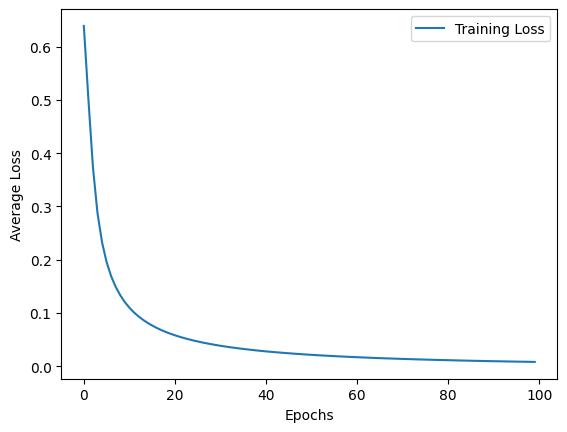

In [296]:
import matplotlib.pyplot as plt  # Import the matplotlib library

# Plotting the training losses after each epoch
plt.plot(np.arange(len(train_losses)), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Average Loss')
plt.legend()
plt.show()